# Swing prediction: models

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to chasing pitches out of the strike zone.

In *swing_prediction_random_forest*, I used random forest to model whether a batter will swing or not. I also used the method to determine a proper set of features to use for modeling. Here, I'll look at other binary classification methods and compare them to random forest.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I'll look at a variety of models for binary classification, specifically naive Bayes, logistic regression, and support vector machines. I'll use features selected in *swing_prediction_random_forest* and focus on making a model Jack Cust again. The techniques examined here can be applied to other individual batters.

## Loading data and creating the response

I'll start by loading information from where a given batter is hitting. For these tests, I'll start with Jack Cust, who was known for three things: hitting home runs, walks, and striking out. I'll create the response (swing or no swing) as well.

In [2]:
# specify database name
dbname = "../../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()
# grab player table
query = """SELECT *
        FROM players"""
players = pd.read_sql_query(query, db)

In [4]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

## Feature pre-processing

I'll now create the set of features selected from *swing_prediction_random_forest*.

In [5]:
# join four tables
features = jc_pitches.merge(jc_events,
                     left_on=['game_id', 'cur_event'],
                     right_on=['game_id', 'event_id'],
                     how='left',) \
              .merge(jc_games,
                     left_on=['game_id'],
                     right_on=['game_id'],
                     how='left',) \
              .merge(players[['player_id', 'throws']].drop_duplicates(),
                     left_on=['pitcher_id'],
                     right_on=['player_id'],
                     how='left',) \
              .sort_values(by=['game_id', 'cur_event'])

# pitch information to calculate gradients of
grad_f = ['start_speed', 'end_speed', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0',
          'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate']
for ff in grad_f:
    features['grad_%s' %(ff)] = -features[ff].diff(1)
    
# get previous pitch swing information
features['prev_swing'] = features['swing'].shift(1)
features['prev_swing'] = features['prev_swing'].fillna(False)
    
# impute nans with column means
features = features.fillna(features.mean())

# pitcher handedness (0: left, 1: right)
features['throws'].replace(['L', 'R'], [0, 1], inplace=True)

# score differential (relative to batter's team)
myteam = features['pre_home_score'].copy()
myteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_away_score']
otherteam = features['pre_away_score'].copy()
otherteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_home_score']
features['my_score'] = myteam
features['other_score'] = otherteam
features['score_diff'] = myteam-otherteam
features = features.drop(['pre_home_score', 'pre_away_score'], axis=1)

# ball-strike differential
features['count_diff'] = features['pre_balls']-features['pre_strike']

In [6]:
# drop columns
dropped_indices = ['index', 'game_id', 'cur_event', 'outcome', 'post_balls', 'post_strike', 'sz_top', 'sz_bot',
                   'y0', 'event_id', 'description', 'event_description', 'post_1b', 'post_2b', 'post_3b', 'post_home',
                   'post_home_score', 'post_away_score', 'game_type', 'game_time', 'home_id', 'visit_id', 'umpire_home',
                   'umpire_first', 'umpire_second', 'umpire_third', 'player_id', 'post_out', 'batter_id', 'pitch_type',
                   'date', 'stadium_id', 'home_wins', 'home_losses', 'visit_wins', 'visit_losses', 'pitcher_id',
                   'at_bat', 'pitch_num', 'x', 'grad_x', 'y', 'grad_y', 'end_speed', 'grad_end_speed','vy0', 
                   'grad_vy0', 'pfx_x', 'grad_pfx_x', 'pfx_z', 'grad_pfx_z', 'break_length', 'grad_break_length']

features = features.drop(dropped_indices, axis=1)

Next I'll split the data into training and test sets.

In [7]:
# import
import sys
sys.path.append('../src')
from split_data import split_data

In [8]:
# creating training and test sets
y = features['swing'].astype('int')
features = features.drop('swing', axis=1)
X_train, X_test, y_train, y_test = split_data(features, y, 0.7, 0)

## Model fitting

I'll now fit the training data through with various models, roughly from less to more flexible (placing random forest first since it was the first model tested).

### Random forest

I'll run the random forest model from *swing_prediction_random_forest*. This is the baseline model, and it likely does a good job of predicting swings since it can handle various feature types and has a track record of good performance.

In [9]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf_fit = RandomForestClassifier(n_estimators=nestimators,
                                criterion='gini',
                                max_features='sqrt',
                                random_state=seed,
                                oob_score=True,).fit(X_train, y_train)

For validating my model, I will look to examine the out-of-bag error, which is similar to cross-validation error. In random forest, a number of decision trees are built on bootstrapped data. Therefore, each tree is likely to leave out a subset of the training data. One can predict the reponse for each data point using results from trees where the data point was not used to build the tree (OOB). The final prediction for each data point is just the majority vote amongst total predictions (in the classification problem). I'll also provide the error on the test set.

In [10]:
# out-of-bag error
print("out-of-bag error: ", 1-rf_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf_fit.predict(X_test)==y_test))

out-of-bag error:  0.228405797101
test error:  0.220930232558


The errors are significantly lower than guessing a non-swing every pitch, which is a promising sign.

### Naive Bayes

Naive Bayes is based on applying Bayes' theorem with strong independence assumptions between features. So given a new data point, based on the data point's features and the training data, compute the probability of each possible label, picking the label with the highest probability.

One effectively computes a number of conditional probabilities and multiplies those probabilities together under the independence assumption. While there are a mix of continuous and categorical features, I will make the assumption that all features have close to Gaussian distributions, which is clearly not the case. Other options (Bernoulli or Multinomial features) describe some of the features but cannot handle the continuous features.

In [11]:
# import
from sklearn.naive_bayes import GaussianNB

# swing classification errors
nb_fit = GaussianNB().fit(X_train, y_train)
print("naive bayes test error: ", 1-np.mean(nb_fit.predict(X_test)==y_test))

naive bayes test error:  0.448320413437


As expected, Naive Bayes does a poor job predicting swings in the test set. Features are unlikely to be completely independent of each other, and not all features will have a Gaussian distribution.

Now I'll remove the non-continuous features and see how naive Bayes performs.

In [12]:
# remove non-continuous features
non_contf = ['time', 'pre_balls', 'pre_strike', 'inning', 'is_top_inning', 'pre_out', 'pre_1b',
             'pre_2b', 'pre_3b', 'throws', 'prev_swing', 'my_score', 'other_score', 'score_diff',
             'count_diff']

Xnb = features.drop(non_contf, axis=1)

In [13]:
# standardize data
Xnb_train, Xnb_test, y_train, y_test = split_data(Xnb, y, 0.7, 0)

In [14]:
# fit naive bayes classifier
nb_fit = GaussianNB().fit(Xnb_train, y_train)
print("naive bayes test error: ", 1-np.mean(nb_fit.predict(Xnb_test)==y_test))

naive bayes test error:  0.339793281654


The classifier does a better job predicting swings in the test set, although still not as good of a job as random forest. The same issues as before (independent features, Gaussian-distributed features) are still issues.

### Logistic regression

Logistic regression models the probability that a batter swings, given some features. Note that I will use cross-validation to determine a value for C, which determines the regularization strength for L2 regularization here. Smaller values correspond to stronger regularization (inverse of regularization strength).

In [15]:
# import
from sklearn.linear_model import LogisticRegressionCV

I'll first look at L2 regularization (ridge), followed by L1 regularization (lasso). I'll use three-fold cross-validation here to estimate the best value of C for each approach. Note that the features should be standardized prior to fitting, as the regularization term in the objective function is directly related to the coefficients and how the features are scaled.

In [16]:
# import
from sklearn.preprocessing import StandardScaler

# calculate scaling values
scaler = StandardScaler().fit(X_train)

# scale data
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

In [17]:
# fit ridge
rseed = 0
logregL2_fit = LogisticRegressionCV(Cs=10,
                                    cv=3,
                                    penalty='l2',
                                    solver='lbfgs',
                                    random_state=rseed,
                                    refit=True).fit(X_train_stand, y_train)
print("logistic regression (ridge) test error: ", 1-np.mean(logregL2_fit.predict(X_test_stand)==y_test))

logistic regression (ridge) test error:  0.391472868217


In [18]:
# fit lasso
logregL1_fit = LogisticRegressionCV(Cs=10,
                                    cv=3,
                                    penalty='l1',
                                    solver='liblinear',
                                    random_state=rseed).fit(X_train_stand, y_train)
print("logistic regression (lasso) test error: ", 1-np.mean(logregL1_fit.predict(X_test_stand)==y_test))

logistic regression (lasso) test error:  0.387596899225


The two models provide similar test errors, with L1 regularization performing slightly better than L2 regularization. This is potentially observed because some of the features might not actually contributing anything to the response (although again the difference in test errors is small). Additionally, both test errors are quite high compared to the other methods (random forest and naive Bayes), potentially because the data are unlikely to be linearly separable (I have not pursued feature transformations, like polynomial representations or product of features, here).

### K-nearest neighbors

Rather than try logistic regression with more features (to estimate a more flexible model), I will look at a non-parametric approach. Specifically, I will look at K-nearest neighbors, which assigns a label to a new data point based on the labels of the nearest points in the training examples. There is no model that needs to be fit before making predictions.

Note that features should be standardized, as distance metrics are used to find the nearest neighbors. Additionally, I will look at both Manhattan and Euclidean distances, as well as both uniform and distance-based weights for neighbors. The reasoning for the former is that Mahattan might be appropriate if different features are not comparable and one wants to place emphasis on outliers, and the reasoning for the latter is that one might want to weight training observations that are more similar to the data point in question.

I will also use cross-validation to determine a reasonable value for K.

In [19]:
# import
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# method variables
weights = ['uniform', 'distance']
distances = ['euclidean', 'manhattan']

# range of K and placeholder for scores
kvals = range(1, 101)
kscores = np.zeros((len(kvals), len(weights), len(distances)))

# cross-validation and k-nearest neighbors
for iww, ww in enumerate(weights):
    for idd, dd in enumerate(distances):
        for ikk, kk in enumerate(kvals):
            knn = KNeighborsClassifier(n_neighbors=kk,
                                       metric=dd,
                                       weights=ww,)
            scores = cross_val_score(knn,
                                     X_train_stand,
                                     y_train,
                                     cv=3,
                                     scoring='accuracy',)
            kscores[ikk, iww, idd] = scores.mean()

In [20]:
# find K, distance, and weights that yield best cross-validation results
ikbest, iwbest, idbest = np.unravel_index(kscores.argmax(), kscores.shape)
print('best K: ', kvals[ikbest])
print('best weight: ', weights[iwbest])
print('best distance: ', distances[idbest])

# run fit
knn_fit = KNeighborsClassifier(n_neighbors=kvals[ikbest],
                               metric=distances[idbest],
                               weights=weights[iwbest],).fit(X_train_stand, y_train)
print("knn test error: ", 1-np.mean(knn_fit.predict(X_test_stand)==y_test))

best K:  56
best weight:  uniform
best distance:  manhattan
knn test error:  0.284237726098


It appears that using the combination of K=56, uniform weighting, and a Manhattan distance metric produces the smallest cross-validation error. Using these parameters to estimate swings on the test set produces the lower test errors than logistic regression and naive Bayes, but not lower than random forest. These results suggest that a non-linear approach might produce the best results here.

### SVM

Support vector machines (SVM) allows for non-linear decision boundaries. I will look at radial basis functions here (linear regression is similar to SVM with a linear kernel), which makes this a non-parametric approach since pairwise distances between training and new points.

I will use cross-validation to find reasonable values for C (which controls the budget for violations of training data points of the margin) and gamma (which controls the local influence of a single training example on the decision boundary). Note that because radial basis functions rely on distances between test observatoins and training observations, I use the standardized features.

In [21]:
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# set values for tuning parameters
tuned_parameters = [{'kernel': ['rbf'],
                     'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000]},]

# use cross validation to find tuning parameters
svm_fit = GridSearchCV(SVC(cache_size=10000,
                           probability=True),
                       tuned_parameters,
                       cv=3,
                       scoring='accuracy').fit(X_train_stand, y_train)

In [22]:
# print best parameters
print("best C: ", svm_fit.best_params_['C'])
print("best gamma: ", svm_fit.best_params_['gamma'])

# calculate test error
print("svm with rbf test error: ", 1-np.mean(svm_fit.predict(X_test_stand)==y_test))

best C:  10
best gamma:  0.01
svm with rbf test error:  0.248062015504


Using the parameters selected through cross-validation, I find a much lower test error than naive Bayes, logistic regression with regularization, and k-nearest neighbors. However, the test error is still higher than from random forest.

## Model comparison

To compare the performance of these different models, I plot the area under the ROC curves for each model and the test set.

In [23]:
# import
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
# calculate false positive and true negative rates
preds = [rf_fit.predict_proba(X_test)[:, 1],
         nb_fit.predict_proba(Xnb_test)[:, 1],
         logregL2_fit.predict_proba(X_test_stand)[:, 1],
         logregL1_fit.predict_proba(X_test_stand)[:, 1],
         knn_fit.predict_proba(X_test_stand)[:, 1],
         svm_fit.predict_proba(X_test_stand)[:, 1]]
dats = ['random forest',
        'naive Bayes',
        'logistic regression--L2',
        'logistic regression--L1',
        'knn',
        'svm',]

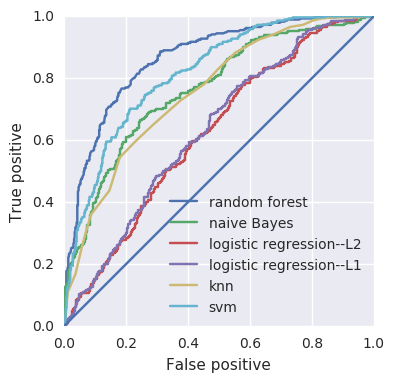

In [25]:
# plot curves
fig, ax = plt.subplots()
for pred in preds:
    false_pos, true_pos, _ = roc_curve(y_test, pred)
    ax.plot(false_pos, true_pos)
ax.plot([0, 1], [0, 1])
ax.legend(dats, loc=4)
ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive')
ax.set_ylabel('True positive')
plt.show()

In [26]:
# calculate area under roc curve
print("Area under ROC curve:")
for ii in range(len(preds)):
    print(dats[ii], ":", roc_auc_score(y_test, preds[ii]))

Area under ROC curve:
random forest : 0.863930256352
naive Bayes : 0.763613368954
logistic regression--L2 : 0.620516682772
logistic regression--L1 : 0.631153015404
knn : 0.755481583584
svm : 0.815810975956


The area under the ROC curves suggest that the two best models are random forest and SVM with radial basis functions. Therefore, I choose my final model to be the random forest model.

In [27]:
# clean up
hdb.close()

## Final thoughts

Random forest displays the best performance in terms of predicting swings from Jack Cust. Swing prediction requires a non-linear model, as logistic regression performed the worst in this binary classification problem. As model flexibility increased, performance tended to improve (given that I used cross-validation to try to avoid overfitting).

Note that while random forest performs the best of these models, feature interpretability is challenging given the bias the resulting feature importance metrics display toward features with more values. Therefore, in this particular case, interpretability is challenging given the many different types of features used (continuous, discrete, binary).

While the performance of random forest is quite good, it should be tested on other batters.